In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Сначала установим и импортируем необходимые библиотеки для выполнения задачи***

In [2]:
!pip install tweedie

In [3]:
import datetime
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from scipy.stats import norm
import statsmodels
import statsmodels.sandbox.stats.multicomp
from statsmodels.stats.weightstats import ztest

from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
import hashlib
import collections
from base64 import b64encode
from sklearn.utils import shuffle

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

# **Дизайн теста**

***Скачиваем и распаковываем хархив из 3 файлов***

In [54]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)


kion dataset download: 100%|██████████| 78.8M/78.8M [00:02<00:00, 34.3MiB/s]

kion dataset download:   1%|▏         | 1.05M/78.8M [00:00<00:07, 9.95MiB/s]
kion dataset download:  29%|██▉       | 23.1M/78.8M [00:00<00:00, 130MiB/s] 
kion dataset download:  64%|██████▍   | 50.3M/78.8M [00:00<00:00, 190MiB/s]
kion dataset download:  96%|█████████▌| 75.5M/78.8M [00:00<00:00, 212MiB/s]

In [18]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [55]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [56]:
interactions.head(5).append(interactions.tail())

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [57]:
users.head()

# user_id - уникальный идентификатор пользователя
# kids_flg = 0 - детей нет, если 1 - дети есть
# income - группа, в которую юзер отнесен по доходу
# age - группа, в которую юзер отнесен по возрасту
# sex - пол

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [58]:
users.groupby('age', as_index=False).count()[['age', 'user_id']]

,age,user_id
0,age_18_24,127672
1,age_25_34,233926
2,age_35_44,207043
3,age_45_54,135925
4,age_55_64,75265
5,age_65_inf,46271


In [ ]:
items.head()

In [60]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [61]:
min_date = interactions['last_watch_dt'].min()
max_date = interactions['last_watch_dt'].max()

print(min_date, max_date)

2021-03-13 2021-08-22


### ***Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)***

In [62]:
check = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=13)]
check

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0
...,...,...,...,...,...
5476215,204332,2081,2021-08-10,822,14.0
5476222,1007900,9728,2021-08-12,416,6.0
5476246,648596,12225,2021-08-13,76,0.0
5476248,697262,15297,2021-08-20,18307,63.0


***Давайте проверим, находится ли дата в интервале, требуемом заданием***

In [63]:
min_date_check = check['last_watch_dt'].min()
max_date_check = check['last_watch_dt'].max()

print(min_date_check, max_date_check)

2021-08-09 2021-08-22


In [64]:
week2 = check.copy()
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})
week2

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


<Axes: >

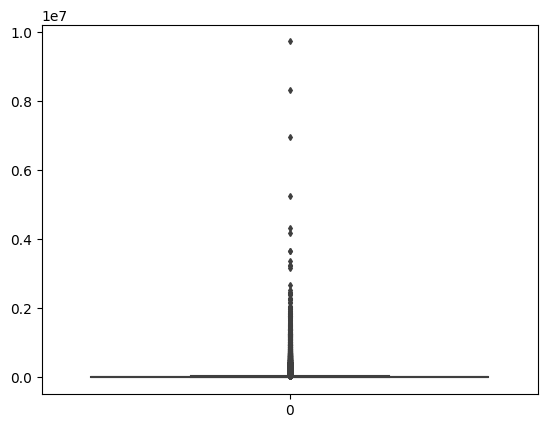

In [65]:
sns.boxplot(week2['total_dur'].values, fliersize=3)

In [66]:
print(week2['total_dur'].max())
print(week2['total_dur'].std())
print(week2['total_dur'].std()*3)

9731801
74040.6760032134
222122.02800964023


In [67]:
# Sort by the values in the total_dur column in descending order
week2_sorted = week2.sort_values(by='total_dur', ascending=False)

# Extract the top 10 rows
top_10 = week2_sorted.head(10)
top_10

,user_id,total_dur
184015,696597,9731801
208959,78911,8318205
212341,801503,6975878
98847,379372,5263297
5425,1019973,4321327
246500,927162,4175405
202647,766071,3670401
2846,1010539,3662468
217106,819006,3379386
66091,257810,3259843


In [68]:
print(week2.shape)
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]
print(week2.shape)

(266081, 2)
(262794, 2)


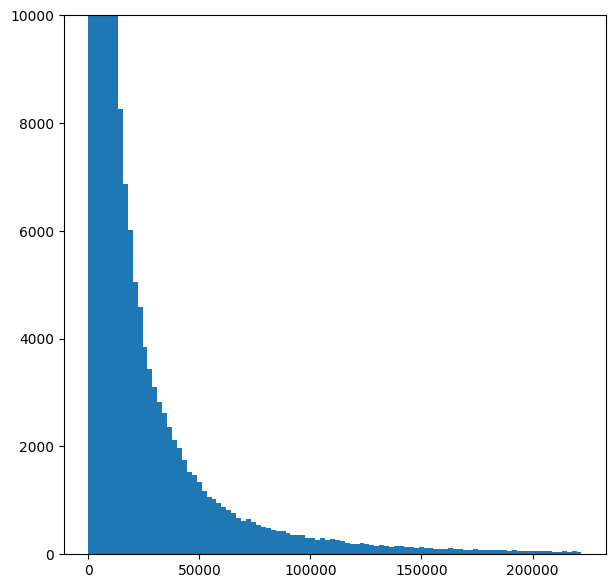

In [69]:
week2['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

### ***Посчитаем на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)***

In [70]:
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [71]:
week2_group = groups_splitter(week2, columns=['user_id', 'total_dur', 'group'], user_salt='20231223')
week2_group.head()

,user_id,total_dur,group
0,1,21172,B
1,1000,10744,A
2,1000000,32990,A
3,1000001,52,B
4,1000003,625,A


In [72]:
week2.groupby(by='group', as_index=False).count()

,group,user_id,total_dur,hash
0,A,131381,131381,131381
1,B,131413,131413,131413


In [73]:
week2_group['group'].value_counts()

B    131413
A    131381
Name: group, dtype: int64

In [74]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [ ]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'\nsignificance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')
print(test_correctness)

100%|██████████| 1000/1000 [2:28:54<00:00,  8.93s/it]


significance: 5.2%
Counter({False: 948, True: 52})


***Как видно, что в нашем случае, получили significance=5.2% за 1000 итераций, это на 0,2% больше, чем significance=5.0%,  полученное за 100 итераций на семинаре.***

### ***На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)***

In [75]:
from tweedie.tweedie_dist import tweedie_gen

def generate_tweedie(mu, shape, p=1.05, phi=25):
    tw = tweedie_gen()
    return tw(p=p, mu=mu, phi=phi).rvs(shape)

In [ ]:
def calc_sample_diff_values(df, add_effect=0):

    new_df = groups_splitter(df, columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    vec_b += generate_tweedie(vec_b.mean() * add_effect, vec_b.shape[0])

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    return sample_a_mean - sample_b_mean

def power_with_progress(df, add_effect=0, n_iter=1000):
    correctness = []
    values = []

    with tqdm(total=n_iter, position=0) as pbar:
        for i in range(n_iter):
            diff = calc_sample_diff_values(df, add_effect=add_effect)
            values.append(diff)

            left_side, right_side = np.percentile(diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

            correctness.append(not left_side <= 0 <= right_side)

            test_correctness = collections.Counter(correctness)

            pbar.update(1)

    return {'effect_size': add_effect,
          'correctness': correctness,
          'values': values,
          'test_correctness': test_correctness}

results_df = week2.copy()
results = Parallel(n_jobs=3)(
    delayed(power_with_progress)(results_df, effect, 1000) for effect in [0.01, 0.03, 0.05]
)

In [ ]:
sizes = []
powers = []

for res in results:
    p_values = np.array([get_p_value(dist) for dist in res['values']])
    _, p_value = stats.kstest(p_values, stats.uniform(loc=0.0, scale=1.0).cdf)

    beta = (p_values > 0.05).mean()

    sizes.append(res["effect_size"])
    powers.append(1 - beta)

    print(f'Effect size: {res["effect_size"]} -> Power: {1 - beta:0.2%}')

Effect size: 0.01 -> Power: 30.80%
Effect size: 0.03 -> Power: 99.20%
Effect size: 0.05 -> Power: 100.00%


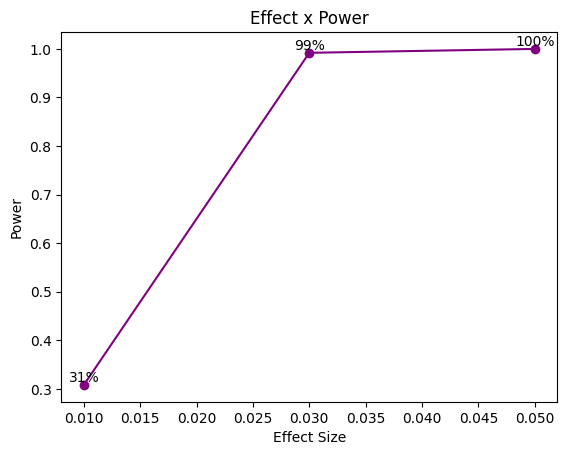

In [ ]:
plt.plot(sizes, powers, marker='o', linestyle='-', color='purple')
plt.title('Effect x Power')
plt.xlabel('Effect Size')
plt.ylabel('Power')
for size, power in zip(sizes, powers):
    plt.text(size, power, f'{power:0.0%}', ha='center', va='bottom')
plt.show()

***После добавления эффекта, полученная мощность составляет:***  
***Размер эффекта: 1% -> Мощность: 30,80%***  
***Размер эффекта: 3% -> Мощность: 99,20%***   
***Размер эффекта: 5% -> Мощность: 100,00%***

### ***Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)***

***Давайте посчитаем MDE, который можно зафиксировать на 2х неделях***

In [77]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

In [84]:
get_mde(results_df['total_dur'], alpha=0.052, beta=0.308)

0.8381031175660216

# **A/B тест**

### ***Представим что у нас прошел тест, используем те же самые данные за 2 недели. Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)***

***В соответствии с требованиями задачи, отфильтровываем всех пользователей < 500 в столбце "total_dur"  и заменяем их на 0***

In [87]:
ab_test = check.copy()
ab_test['total_dur'] = ab_test['total_dur'].apply(lambda x: 0 if x < 500 else x)
ab_test

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0
...,...,...,...,...,...
5476215,204332,2081,2021-08-10,822,14.0
5476222,1007900,9728,2021-08-12,0,6.0
5476246,648596,12225,2021-08-13,0,0.0
5476248,697262,15297,2021-08-20,18307,63.0


### ***Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)***

***В соответствии с требованиями задачи и предоставленными параметрами, разделим их самостоятельно на две равные группы***

In [88]:
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [89]:
ab_test_group = groups_splitter(ab_test, columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805')
ab_test_group

,user_id,total_dur,group
6,1016458,1672,A
9,203219,6975,B
22,505244,15991,A
24,916352,1812,A
30,1057871,5033,A
...,...,...,...
5476215,204332,822,B
5476222,1007900,0,A
5476246,648596,0,B
5476248,697262,18307,A


### ***Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)***

***По описанию задачи, получается, что модель в группе В показала себя лучше, чем в группе А на 2.5%, и преимущественно на 10% самых смотрящих пользователей, поэтому попробуем отнести их всех к группе B***

In [ ]:
group_b_longest = (ab_test_group['group'] == 'B') & (ab_test_group['total_dur'] >= ab_test_group['total_dur'].quantile(q=0.9))
ab_test_group.loc[group_b_longest, 'total_dur'] *= 1 + 0.025

In [ ]:
result_df = ab_test_group.groupby('group')['total_dur'].mean().reset_index()
result_df

,group,total_dur
0,A,7927.232488
1,B,8017.318266


### ***Посчитайте результат такого теста и сделайте выводы (2 балла)***

In [ ]:
vec_a = ab_test_group[(ab_test_group['group'] == 'A')]['total_dur']
vec_b = ab_test_group[(ab_test_group['group'] == 'B')]['total_dur']

sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

left_side, right_side = np.percentile(sample_b_mean - sample_a_mean,
                      [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
print(left_side, right_side)

-101.04189401220795 286.5001177545295


In [ ]:
get_p_value(sample_b_mean - sample_a_mean)

0.3340000000000001

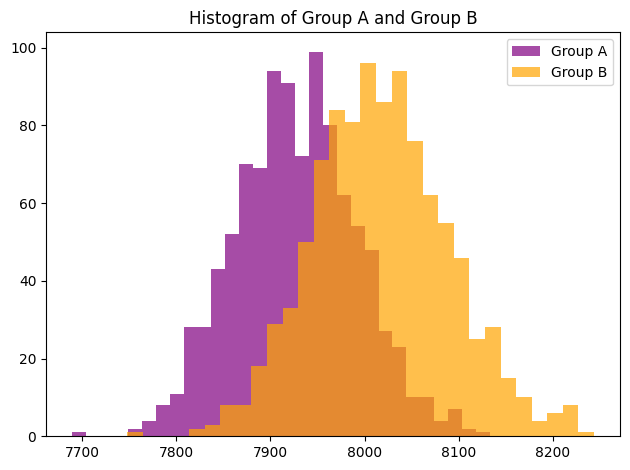

In [ ]:
plt.hist(sample_a_mean, bins=30, color='purple', alpha=0.7, label='Group A')
plt.hist(sample_b_mean, bins=30, color='orange', alpha=0.7, label='Group B')
plt.title('Histogram of Group A and Group B')
plt.legend()
plt.tight_layout()
plt.show()

***Выводы:***  
***Как видно из приведенной выше гистограммы, в группе В среднее время просмотра пользователя существенно не увеличилось.***